Manon LEMAIRE - 12/2022

# **FINAL PROJECT MACHINE LEARNING**

## Text classification: goemotions 
--> Guess the sentiment(s) of the given text passage, among 28 possible labels

# **Importing libraries**

In [22]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

You should consider upgrading via the 'C:\Users\Manon Lemaire\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# **Downloading Data**

In [23]:
train = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
test = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
evaluate = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [24]:
train = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv")
test = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv")
evaluate = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv")

# **Dropping unnecessary columns**

In [25]:
train = train.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
test =test.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
evaluate =evaluate.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)

In [26]:
train.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# **Preprocessing**


In [27]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Manon
[nltk_data]     Lemaire\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Manon
[nltk_data]     Lemaire\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Manon
[nltk_data]     Lemaire\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Manon
[nltk_data]     Lemaire\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Manon
[nltk_data]     Lemaire\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

def preprocess(sentence):
  sentence = nltk.tokenize.word_tokenize(sentence) # tokenizing
  sentence = [i.lower() for i in sentence if i not in string.punctuation] # removing punctuation
  sentence = [i for i in sentence if not i.isdigit()] # removing numbers
  sentence = [i for i in sentence if i not in stopwords] # removing stopwords
  sentence = (lemmatizer.lemmatize(w) for w in sentence) # lemmatizing 
  sentence_clean = ' '.join(w for w in sentence if w.lower() in words or not w.isalpha()) # joining the tokens

  return sentence_clean

In [29]:
before = train['text'][:3]
after = train['text'][:3].apply(preprocess)
print(f'Before: {before.values}\n\nAfter: {after} ')

Before: ['That game hurt.'
 ' >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" '
 "You do right, if you don't care then fuck 'em!"]

After: 0                                            game hurt
1    sexuality ’ grouping category make different f...
2                                   right n't care 'em
Name: text, dtype: object 


In [30]:
tqdm.pandas() # adding a loading bar on the apply process
train['text'] = train.text.progress_apply(preprocess)
test['text'] = test.text.progress_apply(preprocess)

  0%|          | 0/70000 [00:00<?, ?it/s]

  0%|          | 0/70000 [00:00<?, ?it/s]

In [31]:
labels = train.drop(['text'], axis = 1).values
labels_test = test.drop(['text'], axis = 1).values
print(labels.shape, labels_test.shape)

(70000, 28) (70000, 28)


# **Classifier pipeline**

In [32]:
pipe = Pipeline(
    [
        ('vectorizer', TfidfVectorizer()), # word vectorizer
        ('classifier', MultiOutputClassifier(XGBClassifier())) # support vector machine
    ]
)

In [33]:
pipe.fit(train.text, labels)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...)))])

In [34]:
print(f'Accuracy: {accuracy_score(labels_test, pipe.predict(test.text)):.3f}')

Accuracy: 0.093


In [35]:
print(classification_report(labels_test, pipe.predict(test.text), target_names = train.drop(['text'], axis = 1).columns))

                precision    recall  f1-score   support

    admiration       0.66      0.27      0.38      5773
     amusement       0.60      0.09      0.16      3044
         anger       0.47      0.03      0.05      2762
     annoyance       0.53      0.02      0.03      4557
      approval       0.59      0.02      0.05      5785
        caring       0.42      0.04      0.07      1985
     confusion       0.58      0.04      0.07      2388
     curiosity       0.73      0.05      0.09      3190
        desire       0.41      0.06      0.10      1245
disappointment       0.42      0.02      0.03      2894
   disapproval       0.36      0.01      0.01      3798
       disgust       0.58      0.09      0.15      1753
 embarrassment       0.52      0.09      0.15       856
    excitement       0.57      0.06      0.11      1879
          fear       0.54      0.15      0.23      1067
     gratitude       0.88      0.72      0.80      3841
         grief       0.43      0.06      0.10  

C:\Users\Manon Lemaire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manon Lemaire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## --> Analysis of the results

We can have a look at the f1 score of our model. We can see that the model is not that good because the macro avg f1 score is at 0.15 which is really low. We will have a look at the data to see if we can improve the model.

# **Analysis of the dataset**

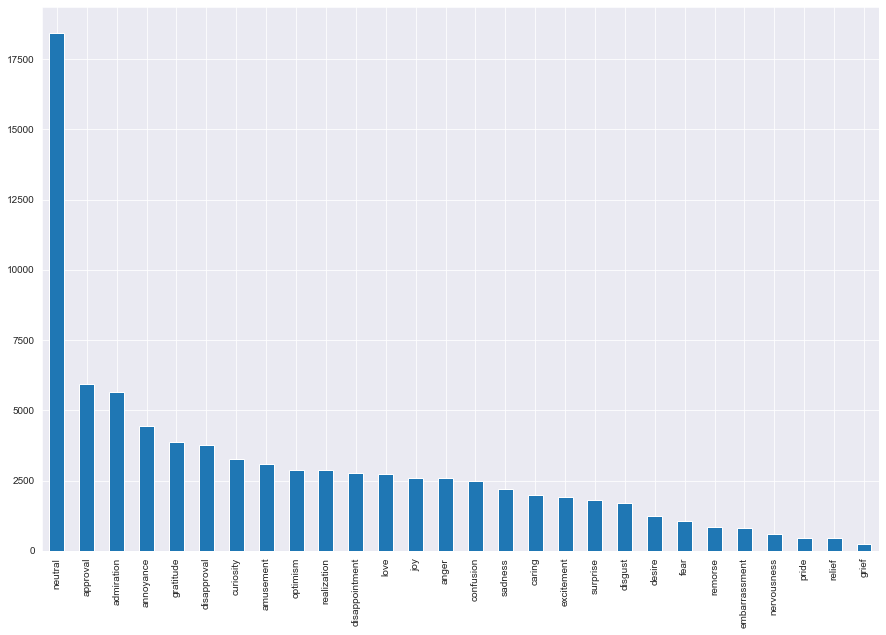

In [36]:
# plot the number of appearances of each emotion in the dataset

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
emotions = train
emotions = emotions.drop(['text'], axis = 1)
emotions.sum(axis = 0, skipna = True).sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

C:\Users\Manon Lemaire\AppData\Local\Temp\ipykernel_12816\383051743.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.hist(train.sum(axis=1))


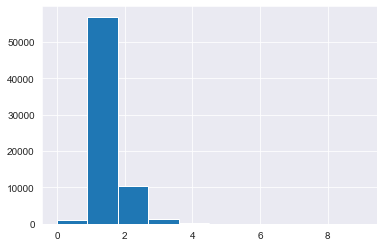

In [37]:
# plot the number of emotions per sentence
plt.hist(train.sum(axis=1))
plt.show()

Some emotions are under represented and some are over represented such as the neutral emotion. We can see that the dataset is not balanced. The idea is to resample the dataset to have a more balanced dataset.

# **Resampling**

In [38]:
train['other'] = train['embarrassment']+ train['grief']+ train['nervousness']+ train['pride']+ train['relief']+ train['remorse']
train['other'] = np.where(train['other'] > 1, 1, 0)

test['other'] = test['embarrassment']+ test['grief']+ test['nervousness']+ test['pride']+ test['relief']+ test['remorse']
test['other'] = np.where(test['other'] > 1, 1, 0)

In [39]:
# classes with more than 1000 samples
to_filter = ['embarrassment', 'grief', 'nervousness', 'pride', 'relief', 'remorse', 'text']
selection = [label for label in train.columns if label not in to_filter]
# selection = [label for label in train.columns if train[label].sum() > 1000]

selection

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'excitement',
 'fear',
 'gratitude',
 'joy',
 'love',
 'optimism',
 'realization',
 'sadness',
 'surprise',
 'neutral',
 'other']

In [40]:
def get_filtered_dataframe(label: str, dataframe: pd.DataFrame, is_training: str) -> pd.DataFrame:
    dataframe = dataframe[dataframe[label] == 1]
    print(f'Number of {is_training} samples for {label}: {dataframe.shape[0]}')
    return dataframe

In [41]:
get_filtered_dataframe('surprise', train, 'training')

Number of training samples for surprise: 1806


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,other
60,could save secrecy-enabled corruption,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
106,shockingly close reality,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
112,housewife ’ even imagine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
178,people hate name really really hate ’ quite fa...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
200,something 's wrong top post r/conspiracy n't c...,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69868,name damn autistic,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
69891,always never “ muscle ” movie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
69924,oh goodness 's like happy little cloud breed e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
69971,dress trailer trash appropriate run money good...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
filtered_train_dataframes, filtered_test_dataframes = {}, {} # creating dictionaries of filtered dataframes
for label in selection:
  filtered_train_dataframes[label] = get_filtered_dataframe(label, train, is_training='training')
  filtered_test_dataframes[label] = get_filtered_dataframe(label, test, is_training='testing')

Number of training samples for admiration: 5647
Number of testing samples for admiration: 5773
Number of training samples for amusement: 3081
Number of testing samples for amusement: 3044
Number of training samples for anger: 2589
Number of testing samples for anger: 2762
Number of training samples for annoyance: 4443
Number of testing samples for annoyance: 4557
Number of training samples for approval: 5928
Number of testing samples for approval: 5785
Number of training samples for caring: 1988
Number of testing samples for caring: 1985
Number of training samples for confusion: 2471
Number of testing samples for confusion: 2388
Number of training samples for curiosity: 3267
Number of testing samples for curiosity: 3190
Number of training samples for desire: 1248
Number of testing samples for desire: 1245
Number of training samples for disappointment: 2771
Number of testing samples for disappointment: 2894
Number of training samples for disapproval: 3774
Number of testing samples for d

In [43]:
def sample_dataframes(dataframe: pd.DataFrame) -> pd.DataFrame:
    try: 
        return dataframe.sample(1500)
    except ValueError:
        return dataframe.sample(dataframe.shape[0]) # if there are less than 1500 samples in the filtered dataframe, we take all the samples

In [44]:
for label, dataframe in filtered_train_dataframes.items():
    dataframe = sample_dataframes(dataframe)
    print(label,dataframe.shape) # number of filtered samples for each label

balanced = pd.concat([frame for frame in filtered_train_dataframes.values()])

admiration (1500, 30)
amusement (1500, 30)
anger (1500, 30)
annoyance (1500, 30)
approval (1500, 30)
caring (1500, 30)
confusion (1500, 30)
curiosity (1500, 30)
desire (1248, 30)
disappointment (1500, 30)
disapproval (1500, 30)
disgust (1500, 30)
excitement (1500, 30)
fear (1048, 30)
gratitude (1500, 30)
joy (1500, 30)
love (1500, 30)
optimism (1500, 30)
realization (1500, 30)
sadness (1500, 30)
surprise (1500, 30)
neutral (1500, 30)
other (103, 30)


In [76]:
pipe.fit(balanced.text, balanced.drop(['text'], axis=1))

TypeError: drop() got an unexpected keyword argument 'epochs'

In [46]:
y_pred = pipe.predict(test.text)
y_test = test.drop(['text'], axis=1)
print(classification_report(y_test, y_pred, target_names = y_test.columns))

                precision    recall  f1-score   support

    admiration       0.63      0.32      0.43      5773
     amusement       0.56      0.11      0.18      3044
         anger       0.40      0.03      0.05      2762
     annoyance       0.45      0.02      0.04      4557
      approval       0.53      0.04      0.07      5785
        caring       0.39      0.05      0.09      1985
     confusion       0.50      0.04      0.08      2388
     curiosity       0.66      0.05      0.10      3190
        desire       0.38      0.07      0.12      1245
disappointment       0.36      0.02      0.05      2894
   disapproval       0.32      0.01      0.02      3798
       disgust       0.53      0.10      0.17      1753
 embarrassment       0.54      0.04      0.08       856
    excitement       0.52      0.08      0.13      1879
          fear       0.52      0.16      0.25      1067
     gratitude       0.87      0.73      0.79      3841
         grief       0.19      0.02      0.03  

C:\Users\Manon Lemaire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Manon Lemaire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **TensorFlow method**

In [68]:
train = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv")
test = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv")
evaluate = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv")

train = train.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
test =test.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
evaluate =evaluate.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)

In [69]:
!pip install tensorflow==2.0.0
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.0.0
You should consider upgrading via the 'C:\Users\Manon Lemaire\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [70]:
# train
labels_train = train.drop(['text'], axis = 1)
labels_train = np.array(labels_train)
# validation
labels_val = evaluate.drop(['text'], axis = 1)
labels_val = np.array(labels_val)
# test
#test['text'] = pd.Series(test['text'])
labels_test = test.drop(['text'], axis = 1)
labels_test = np.array(labels_test)

In [71]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# tokenize : breaking the sentences into word parts
# create an element token
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# fit it on train data
tokenizer.fit_on_texts(train["text"])

# tokenize the text with the same size
sequences_training_words = tokenizer.texts_to_sequences(train["text"])
padded_train = pad_sequences(sequences_training_words,maxlen=max_length, truncating=trunc_type)
padded_train = np.array(padded_train)

# validation
sequences_val_words = tokenizer.texts_to_sequences(evaluate["text"])
padded_val = pad_sequences(sequences_val_words,maxlen=max_length, truncating=trunc_type)
padded_val = np.array(padded_val)

# test
sequences_testing_words = tokenizer.texts_to_sequences(test["text"])
padded_test = pad_sequences(sequences_testing_words,maxlen=max_length, truncating=trunc_type)
padded_test = np.array(padded_test)

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
num_epochs = 10
history = model.fit(padded_train, labels_train, epochs=num_epochs, validation_data=(padded_val, labels_val), verbose=2)

Epoch 1/10
2188/2188 - 14s - loss: 0.1775 - accuracy: 0.2491 - val_loss: 0.1565 - val_accuracy: 0.2614 - 14s/epoch - 6ms/step
Epoch 2/10
2188/2188 - 12s - loss: 0.1562 - accuracy: 0.2632 - val_loss: 0.1561 - val_accuracy: 0.2614 - 12s/epoch - 5ms/step
Epoch 3/10
2188/2188 - 12s - loss: 0.1554 - accuracy: 0.2632 - val_loss: 0.1551 - val_accuracy: 0.2614 - 12s/epoch - 5ms/step
Epoch 4/10
2188/2188 - 12s - loss: 0.1526 - accuracy: 0.2743 - val_loss: 0.1498 - val_accuracy: 0.2925 - 12s/epoch - 5ms/step
Epoch 5/10
2188/2188 - 12s - loss: 0.1466 - accuracy: 0.3044 - val_loss: 0.1455 - val_accuracy: 0.3060 - 12s/epoch - 5ms/step
Epoch 6/10
2188/2188 - 12s - loss: 0.1425 - accuracy: 0.3216 - val_loss: 0.1426 - val_accuracy: 0.3251 - 12s/epoch - 5ms/step
Epoch 7/10
2188/2188 - 12s - loss: 0.1394 - accuracy: 0.3347 - val_loss: 0.1407 - val_accuracy: 0.3326 - 12s/epoch - 5ms/step
Epoch 8/10
2188/2188 - 12s - loss: 0.1367 - accuracy: 0.3474 - val_loss: 0.1394 - val_accuracy: 0.3409 - 12s/epoch - 5

In [74]:
# print f1 score for tensorflow model 
from sklearn.metrics import f1_score
predictions = model.predict(padded_test)
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)
labels_test = np.argmax(labels_test, axis=1)
print(f1_score(labels_test, predictions, average='micro'))


2188/2188 [==============================] - 5s 2ms/step
0.3506142857142857


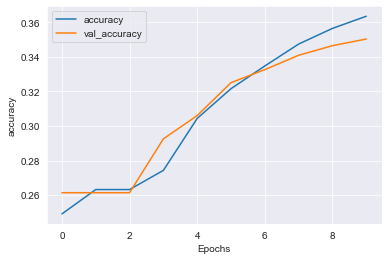

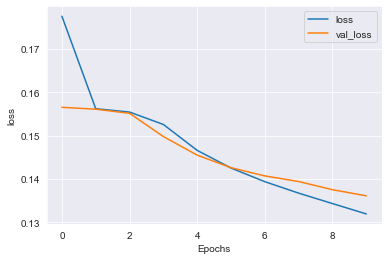

In [75]:
# plot the loss and accuracy for the training and validation sets

import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# make an example
example = ["I am so happy to see you again"]
# tokenize the example
sequences_example_words = tokenizer.texts_to_sequences(example)
# pad the example
padded_example = pad_sequences(sequences_example_words,maxlen=max_length, truncating=trunc_type)
# predict the example
predictions = model.predict(padded_example)
# print the prediction
print(predictions)

# transform the prediction into the emotion label
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)
print(predictions)

In [79]:
# print the first column of the train data without the text
print(train.columns[1])

admiration
